# __Neural Networks in Scikit-Learn and NumPy (Part B)__

In _Part A_, we looked at the Scikit-Learn Multi-layer Perceptron (MLP) object for building a neural network classifier.

Now let's use NumPy We take this a step further with NumPy's more flexible, general, framework to build and train a neural network for the same problem.

__As before from Part A__

General imports

In [1]:
%matplotlib inline  
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

Generate some tricky data!

In [2]:
X, y = make_moons(n_samples = 500, noise = 0.2, random_state = 101)

Split the data into training and test sets

In [3]:
# insert code here to split the data into 80:20 training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

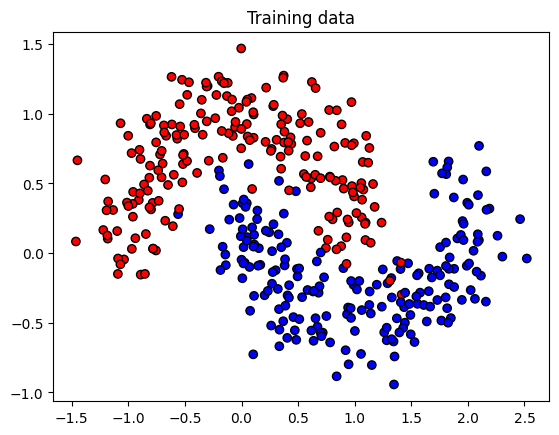

In [4]:
# visualise the training data
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
fig, ax = plt.subplots()
ax.scatter(X_train[:,0], X_train[:,1], c = y_train, edgecolors='k', cmap = cm_bright)
plt.title('Training data')
plt.show()

__New for Part B__

To build a neural network classifier at a lower level than available in Scikit-Learn, we need to think first about the "ingredients" that we require.
- Definition of the model to do a __forward pass__: $y = \sigma(W^{[L-1]}(\sigma(W^{[L-2]}(... \sigma(W^{[1]}x + b^{[1]})...)+b^{[L-2]}))+b^{[L-1]})$ where 
    - $\sigma$ is the __activation function__
    - $Wx + b$ is a linear function that goes from $\mathbb{R}^n$ to $\mathbb{R}^m$.
    - In our example, the output of the model is a value between 0 and 1 that tells the probability of a point being blue or red. The input of the model are the coordinates of the point. 
- Definition of a __cost function__ that tells how good is the model in terms of its parameters: $$J(\theta), \text{where } \theta:=\{W^{[1]}, b^{[1]}, \ldots, W^{[L-1]}, b^{[L-1]}\}$$
- __Optimisation__ of the cost function using gradient descent.
    - We need to apply the chain rule (backpropagation) in order to obtain $\partial_{\theta}J$ for each optimisation step.

__Activation Function__ - sigmoid

In [5]:
def sigmoid(z):
    output = 1/(1+np.exp(-z))
    return output

__Forward Model Definition__

In [6]:
def forward_model(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # forward pass
    # we use a single hidden layer
    z2 = np.matmul(x,W1) + b1
    a2 = sigmoid(z2)
    
    # output layer
    z3 = np.matmul(a2,W2) + b2
    a3 = sigmoid(z3)
    
    #return the output of the model (a3) and the intermediate layers
    return z2, a2, z3, a3

__Loss function__

Let $\mathcal{D} = \{(x^1, y^1), (x^2, y^2), \ldots, (x^N, y^N)\}$ be our training set, where $x^i\in \mathbb{R}^n$
We define the loss function as $$J(\theta) = \sum_{i=1}^{N} y^i \log(f_{\theta}(x^i)) + (1-y^i) \log(1-f_{\theta}(x^i))$$

In [7]:
def loss_fn(model, x, y):
    _,_,_,y_pred = forward_model(model, x)
    loss_batch = y * np.log(y_pred) + (1-y) * np.log(1-y_pred)
    return -np.sum(loss_batch)

__Optimisation__ Gradient Descent algorithm
- Update the weights and biases in the neural network according to the gradient of the cost function.

In [8]:
def GD_step(model, x, y, lr = 0.001):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    z2, a2, z3, a3 = forward_model(model, x)
    
    delta3 = a3-y
    dW2 = np.matmul(a2.T,delta3)
    db2 = np.sum(delta3, axis=0, keepdims=True)
    
    delta2 = sigmoid(z2)*(1-sigmoid(z2)) * delta3.dot(W2.T)
    dW1 = np.matmul(x.T, delta2)
    db1 = np.sum(delta2, axis=0)
    
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    
    model['W1'], model['b1'], model['W2'], model['b2'] = W1, b1, W2, b2
    return model

#### We put everything together for the training:
- Initialise $W^{[1]}, b^{[1]}, \ldots, W^{[L-1]}, b^{[L-1]}$.
- While Not convergence:
    - Calculate $J(\theta)$
    - Update $W^{[i]} := W^{[i]} - \alpha \cdot \partial_{W^{[i]}}J$
    - Update $b^{[i]} := b^{[i]} - \alpha \cdot \partial_{b^{[i]}}J$
    

__Define the training function__

In [9]:
def train(model, n_epochs, X, y):
    # for a pre-defined number of epochs
    for epoch in range(n_epochs):
        # update weights and biases
        model = GD_step(model, x=X, y=y)
        # calculate loss
        loss = loss_fn(model, x=X, y=y)
        # print information every 100 epochs
        if epoch%100 == 0:
            print("Epoch: {}/{}, loss: {}".format(epoch, n_epochs, loss))
    return model

__Now run the training__

In [10]:
%%time
n_hidden = 30
# Initialise weights and biases
W1 = np.random.randn(2, n_hidden)
b1 = np.random.randn(1, n_hidden)
W2 = np.random.randn(n_hidden, 1)
b2 = np.random.randn(1,1)
model = {} # the model is a Dictionary
model['W1'], model['b1'], model['W2'], model['b2'] = W1, b1, W2, b2

# Train for 10000 epochs
model = train(model=model, n_epochs=10000, X=X, y=y.reshape(500,1))

Epoch: 0/10000, loss: 256.80601673556885
Epoch: 100/10000, loss: 131.9466043454442
Epoch: 200/10000, loss: 122.83252536730762
Epoch: 300/10000, loss: 114.14152345783381
Epoch: 400/10000, loss: 105.31151798332941
Epoch: 500/10000, loss: 96.92058651749987
Epoch: 600/10000, loss: 89.4046838961117
Epoch: 700/10000, loss: 82.91278629553597
Epoch: 800/10000, loss: 77.39647205517859
Epoch: 900/10000, loss: 72.7253394893936
Epoch: 1000/10000, loss: 68.75569316019701
Epoch: 1100/10000, loss: 65.35840778324734
Epoch: 1200/10000, loss: 62.42621610736828
Epoch: 1300/10000, loss: 59.87295376177252
Epoch: 1400/10000, loss: 57.63036303966415
Epoch: 1500/10000, loss: 55.64460668274944
Epoch: 1600/10000, loss: 53.8731960932047
Epoch: 1700/10000, loss: 52.28248433834298
Epoch: 1800/10000, loss: 50.8456845439157
Epoch: 1900/10000, loss: 49.541324739003855
Epoch: 2000/10000, loss: 48.35205005979094
Epoch: 2100/10000, loss: 47.26369714019019
Epoch: 2200/10000, loss: 46.264580848861485
Epoch: 2300/10000, lo

__Accuracy Metric:__

- _Use ideas from the code in Practical8a.ipynb to calculate the accuracy of the model._

- _Can you write this this code as a function and incorporate it into the print statement in the training function to track the accuracy during optimisation._
    - _remember, the loss function, not the accuracy metric, is used to improve the model!_

__Visualise:__
- _Adapt code from the from Practical8a.ipynb to plot the decision boundaries of the model_
- _Do the boundaries make more sense visually?_

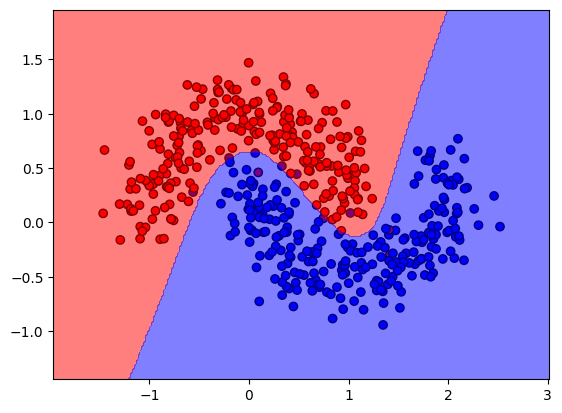

In [11]:
_,_,_,y_pred = forward_model(model, X)
y_pred = y_pred.ravel()

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y.ravel(), edgecolors='k', cmap = cm_bright)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.02 # step in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
_,_,_,Z = forward_model(model=model, x=np.c_[xx.ravel(), yy.ravel()])
Z_binary = Z>=0.5
Z_binary = Z_binary.reshape(xx.shape)
ax.contourf(xx, yy, Z_binary, cmap=cm_bright, alpha=.5)